In [6]:
library(RColorBrewer)
library(microbiome)
library(phyloseq)
library(dplyr)
library(ggpubr)
library(mia)


Attaching package: 'dplyr'


The following objects are masked from 'package:Biostrings':

    collapse, intersect, setdiff, setequal, union


The following object is masked from 'package:XVector':

    slice


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following object is masked from 'package:matrixStats':

    count


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    interse

In [2]:
metadata_raw <- read.table(file = "R files/Carbon_analysis/sample-metadata3.txt", sep = "\t", header =  T, skip = 1)%>%
                mutate(sample_ref = sample.id) %>%  
                dplyr::select(-sample_ID) %>%
                tidyr::separate(sample_ref, into = c("read_prefix", "Sample_ID"," replicate_id"), sep =  "[.]") %>%
                mutate(Sample_ID = stringi::stri_replace_last_fixed(Sample_ID, "_", ""))
metadata_sediment <- metadata_raw %>% dplyr::select(sample.id, Sample_ID) 
rownames(metadata_sediment) <- metadata_sediment$sample.id
#list of the 45 samples identifier no replicates
otu_sediment <- read.table(file = "feature-table.tsv", sep = "\t", header = T, row.names = 1, skip = 1, comment.char = "")
tax_sediment_raw <- read.table(file = "taxonomy.tsv", sep = "\t", header = T ,row.names = 1)
tax_sediment <- tax_sediment_raw %>% 
                tidyr::separate(Taxon, c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"), sep = "; ") %>%
                dplyr::mutate(across(1:7, ~ stringr::str_replace_all(.x, "^[dkpcofgs]__",""))) %>%
                dplyr::select(1:7)

Warning message:
"Expected 7 pieces. Missing pieces filled with `NA` in 18661 rows [1, 2, 5, 6, 8, 9, 11, 12, 14, 15, 16, 21, 22, 24, 25, 30, 31, 32, 33, 34, ...]."


In [3]:
OTU_sediment <- otu_table(as.matrix(otu_sediment), taxa_are_rows = TRUE)
TAX_sediment <- tax_table(as.matrix(tax_sediment))
SAMPLE_sediment <- sample_data(metadata_sediment)
(ps_sediment_all <- phyloseq(OTU_sediment, TAX_sediment, SAMPLE_sediment))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 48190 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 48190 taxa by 7 taxonomic ranks ]

In [4]:
#merge replicates by summing up all readcounts data for the given category
(merged_ps <- merge_samples(ps_sediment_all, "Sample_ID"))

Warning message in asMethod(object):
"NAs introduced by coercion"
Warning message in asMethod(object):
"NAs introduced by coercion"


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 48190 taxa and 45 samples ]
sample_data() Sample Data:       [ 45 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 48190 taxa by 7 taxonomic ranks ]

In [7]:
#preparing the metadata table
metadata_table <-  metadata_raw %>% 
                   dplyr::select_if(is.character) %>% 
                   dplyr::select(Sample_ID, estuary.reach, ecosystem, sediment.water) %>% 
                   dplyr::mutate_if(is.factor, as.character)  %>%
                   distinct()
row.names(metadata_table) <- metadata_table$Sample_ID
#add sediment metadata as it gets lost during merge
(merged_sediment_ps <- merge_phyloseq(merged_ps, sample_data(metadata_table)))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 48190 taxa and 45 samples ]
sample_data() Sample Data:       [ 45 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 48190 taxa by 7 taxonomic ranks ]

In [8]:
#water data
metadata_water <-   read.table(file = "water//sample-metadata.tsv", sep = "\t", header =  T) %>%
                    dplyr::mutate(sample_ref = sample.id)  %>%
                    tidyr::separate(sample_ref, into = c("read_prefix", "Sample_ID"), sep =  "[.]") %>%
                    select(sample.id, Sample_ID, estuary.reach,	ecosystem, sediment.water) 
row.names(metadata_water) <- metadata_water$sample.id
otu_water <- read.table(file = "water//feature-table.tsv", sep = "\t", header = T, row.names = 1, skip = 1, comment.char = "")
tax_water_raw <- read.table(file = "water//taxonomy.tsv", sep = "\t", header = T ,row.names = 1)
tax_water <- tax_water_raw %>% 
             tidyr::separate(Taxon, c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"), sep = "; ") %>%
             dplyr::mutate(across(1:7, ~ stringr::str_replace_all(.x, "^[dkpcofgs]__",""))) %>%
             dplyr::select(1:7)

Warning message:
"Expected 7 pieces. Missing pieces filled with `NA` in 1552 rows [1, 2, 4, 5, 6, 8, 12, 13, 15, 16, 17, 19, 20, 24, 25, 26, 27, 28, 29, 30, ...]."


In [9]:
OTU_water <- otu_table(as.matrix(otu_water), taxa_are_rows = TRUE)
TAX_water <- tax_table(as.matrix(tax_water))
SAMPLE_water <- sample_data(metadata_water)
#phyloseq for water
(water_ps <- phyloseq(OTU_water, TAX_water, SAMPLE_water))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3636 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3636 taxa by 7 taxonomic ranks ]

In [10]:
#https://microbiome.github.io/OMA/microbiome-exploration.html
#each class now has its own uuids
glom_sediment_ps <- phyloseq::tax_glom(merged_sediment_ps, taxrank = "Class")

In [11]:
#These abitrary can play around with to find a good cuttoff
#This ensures that we drop any rare tax will low abundance and not prevalent in all the classes  
sediment_classes <- core_members(glom_sediment_ps,
                    detection = 0.001, #% relative abundance 
                    prevalence = 0.25) #% of the samples

In [12]:
glom_sediment_ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 207 taxa and 45 samples ]
sample_data() Sample Data:       [ 45 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 207 taxa by 7 taxonomic ranks ]

In [13]:
#We keep those taxa meeting our criteria we lose a few classes but thats okay
(filtered_sediment_ps <- subset_taxa(glom_sediment_ps, colnames(otu_table(glom_sediment_ps)) %in% sediment_classes))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 167 taxa and 45 samples ]
sample_data() Sample Data:       [ 45 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 167 taxa by 7 taxonomic ranks ]

In [14]:
#combine counts at the Class level 
#we can also remove rare samples here as well...
(glom_water_ps <- phyloseq::tax_glom(water_ps, taxrank = "Class"))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 128 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 128 taxa by 7 taxonomic ranks ]

In [15]:
water_classes <- data.frame(tax_table(glom_water_ps))$Class
sediment_classes <- data.frame(tax_table(filtered_sediment_ps))$Class

In [16]:
#Moment of truth 
#We check the for those sediment classes not in water
`%nin%` <- Negate(`%in%`)
(core_sediment_classes <- subset_taxa(filtered_sediment_ps, sediment_classes %nin% water_classes))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 42 taxa and 45 samples ]
sample_data() Sample Data:       [ 45 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 42 taxa by 7 taxonomic ranks ]

In [17]:
##Prevalence is a measurement, which describes in how many samples certain microbes were detected.
#Detection threshold for absence/presence (strictly greater by default).
#https://f1000research.com/articles/5-1492/v2
# Compute prevalence of each feature, store as data.frame
prevdf = apply(X = otu_table(core_sediment_classes),
                 MARGIN = ifelse(taxa_are_rows(core_sediment_classes), yes = 1, no = 2),
                 FUN = function(x){sum(x > 0)})
#Add taxonomy and total read counts to this data.frame
prevdf = data.frame(N_samples = prevdf,
                     Perc_Prev = prevdf/nsamples(core_sediment_classes),
                     TotalAbundance = taxa_sums(core_sediment_classes),
                     PercAbundance =  taxa_sums(core_sediment_classes)/sum(taxa_sums(core_sediment_classes)),
                     tax_table(core_sediment_classes)) %>% 
                     arrange(desc(PercAbundance)) %>%
                     dplyr::mutate(Class = factor(Class, level= rev(Class)))

Using Class as id variables



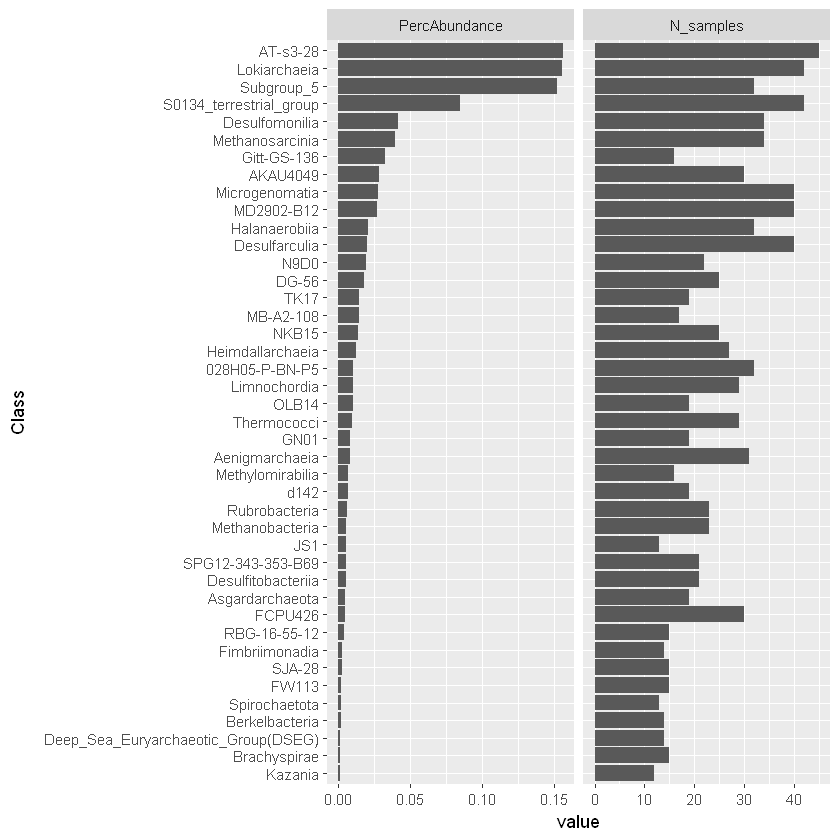

In [21]:
prevdf %>%
dplyr::select(Class,PercAbundance, N_samples, ) %>%
reshape2::melt() %>%
ggplot(aes(x = Class, y  = value)) +
geom_bar(stat ="identity") +
coord_flip() + 
facet_wrap(~variable, scale = "free_x")

 [1] "0.1%"               "0.139440490670355%" "0.194436504383895%"
 [4] "0.271123215755189%" "0.378055542370282%" "0.527162503287594%"
 [7] "0.73507798121435%"  "1.02499634381503%"  "1.42925993116888%" 
[10] "1.99296706097667%"  "2.77900304872443%"  "3.87505548688548%" 
[13] "5.40339638466164%"  "7.53452243163643%"  "10.5061750483418%" 
[16] "14.6498620380943%"  "20.4278395084488%"  "28.4846796439337%" 


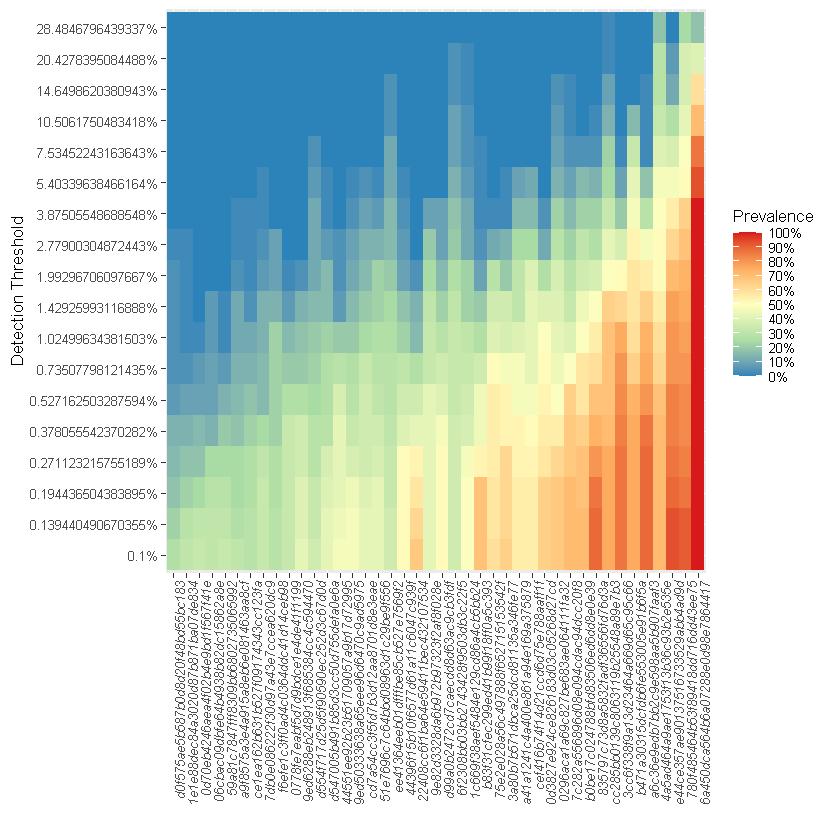

In [19]:
#https://microbiome.github.io/tutorials/Core.html
# Core with absolute counts and horizontal view:
# and minimum population prevalence (given as percentage)
pseq_rel <- microbiome::transform(core_sediment_classes, "compositional")

#detections <- seq(from = 50, to = round(max(abundances(pseq_rel))/10, -1), by = 100)
prevalences <- seq(.05, 1, .05)

#very strange plot but can be reproduced in pure ggplot
plot_core(pseq_rel, plot.type = "heatmap",
            colours = rev(brewer.pal(5, "Spectral")),
               min.prevalence = .2, horizontal = TRUE) +
  theme(axis.text.x= element_text(size=8, face="italic", hjust=1),
        axis.text.y= element_text(size=8),
        axis.title = element_text(size=10),
        legend.text = element_text(size=8),
        legend.title = element_text(size=10))

